In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import yaml
import json
import pandas as pd
sys.path.append(".")
sys.path.append("../")
sys.path.append("../../")
import numpy as np
import torch.nn.functional as F
import src.utils.io as io   
import src.utils.functionalities as func
import torch
import config as config
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import src.utils.preprocess as preprocess
from src.eval.eval_utils import evaluate_label_distribution
from torch.utils.data import DataLoader
import src.methods.dann as dann
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [4]:
print("Loading source data (Vectronics)...")
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

min_duration_before_padding = 15.0
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(min_duration_before_padding))
X_src = torch.tensor(vectronics_df[Vectronics_feature_cols].values, dtype=torch.float32)
y_src = vectronics_df['behavior'].values
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)
y_src = torch.tensor(y_src, dtype=torch.long)

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
X_targets = [torch.tensor(RVC_df.loc[RVC_df.firmware_major_version == 2.0, Vectronics_feature_cols].values, dtype=torch.float32),
            torch.tensor(RVC_df.loc[RVC_df.firmware_major_version == 3.0, Vectronics_feature_cols].values, dtype=torch.float32)]


Loading source data (Vectronics)...
Loading target data (RVC)...


In [5]:
# --------------------------
# Preprocess (compute quantiles using all domains)
# --------------------------
pos_idx = [0, 1, 2, 3, 4, 5]  # Indices of features that should be positive
center_idx = None  # Indices of features that should be centered at zero

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=pos_idx,
    center_idx=center_idx,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=pos_idx,
    center_idx=center_idx,
    lows=lows,
    highs=highs,
    clip_to_quantile=False
)

X_src = transform(X_src)
X_targets = [transform(Xt) for Xt in X_targets]
target_loaders = [DataLoader(Xt, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True) for Xt in X_targets]

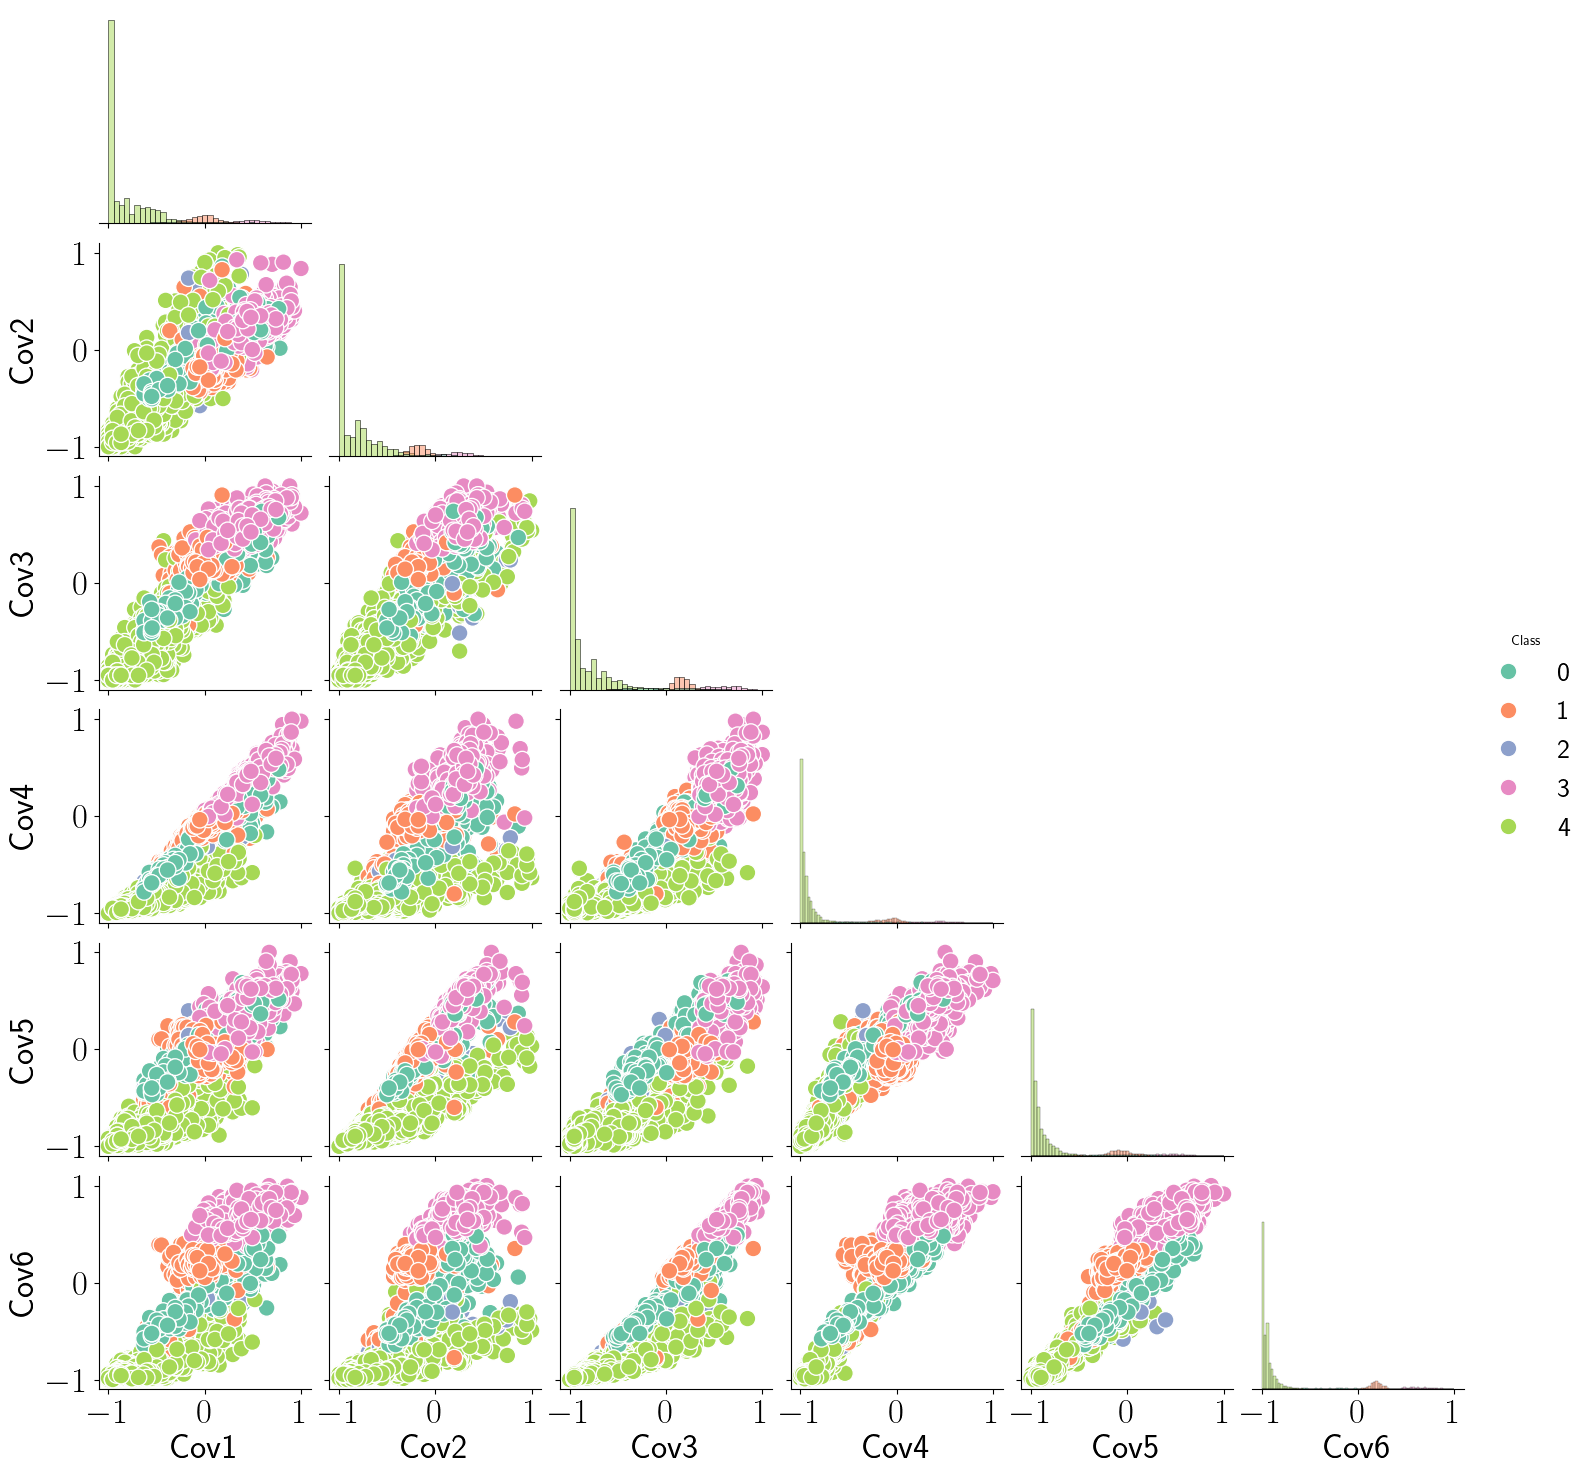

In [6]:
X_df = pd.DataFrame(X_src, columns=[f"Cov{i+1}" for i in range(X_src.shape[1])])
X_df['Class'] = y_src

sns.pairplot(X_df, hue='Class', corner=True, diag_kind='hist', palette='Set2')
plt.show()


/tmp/ipykernel_3712409/984153823.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


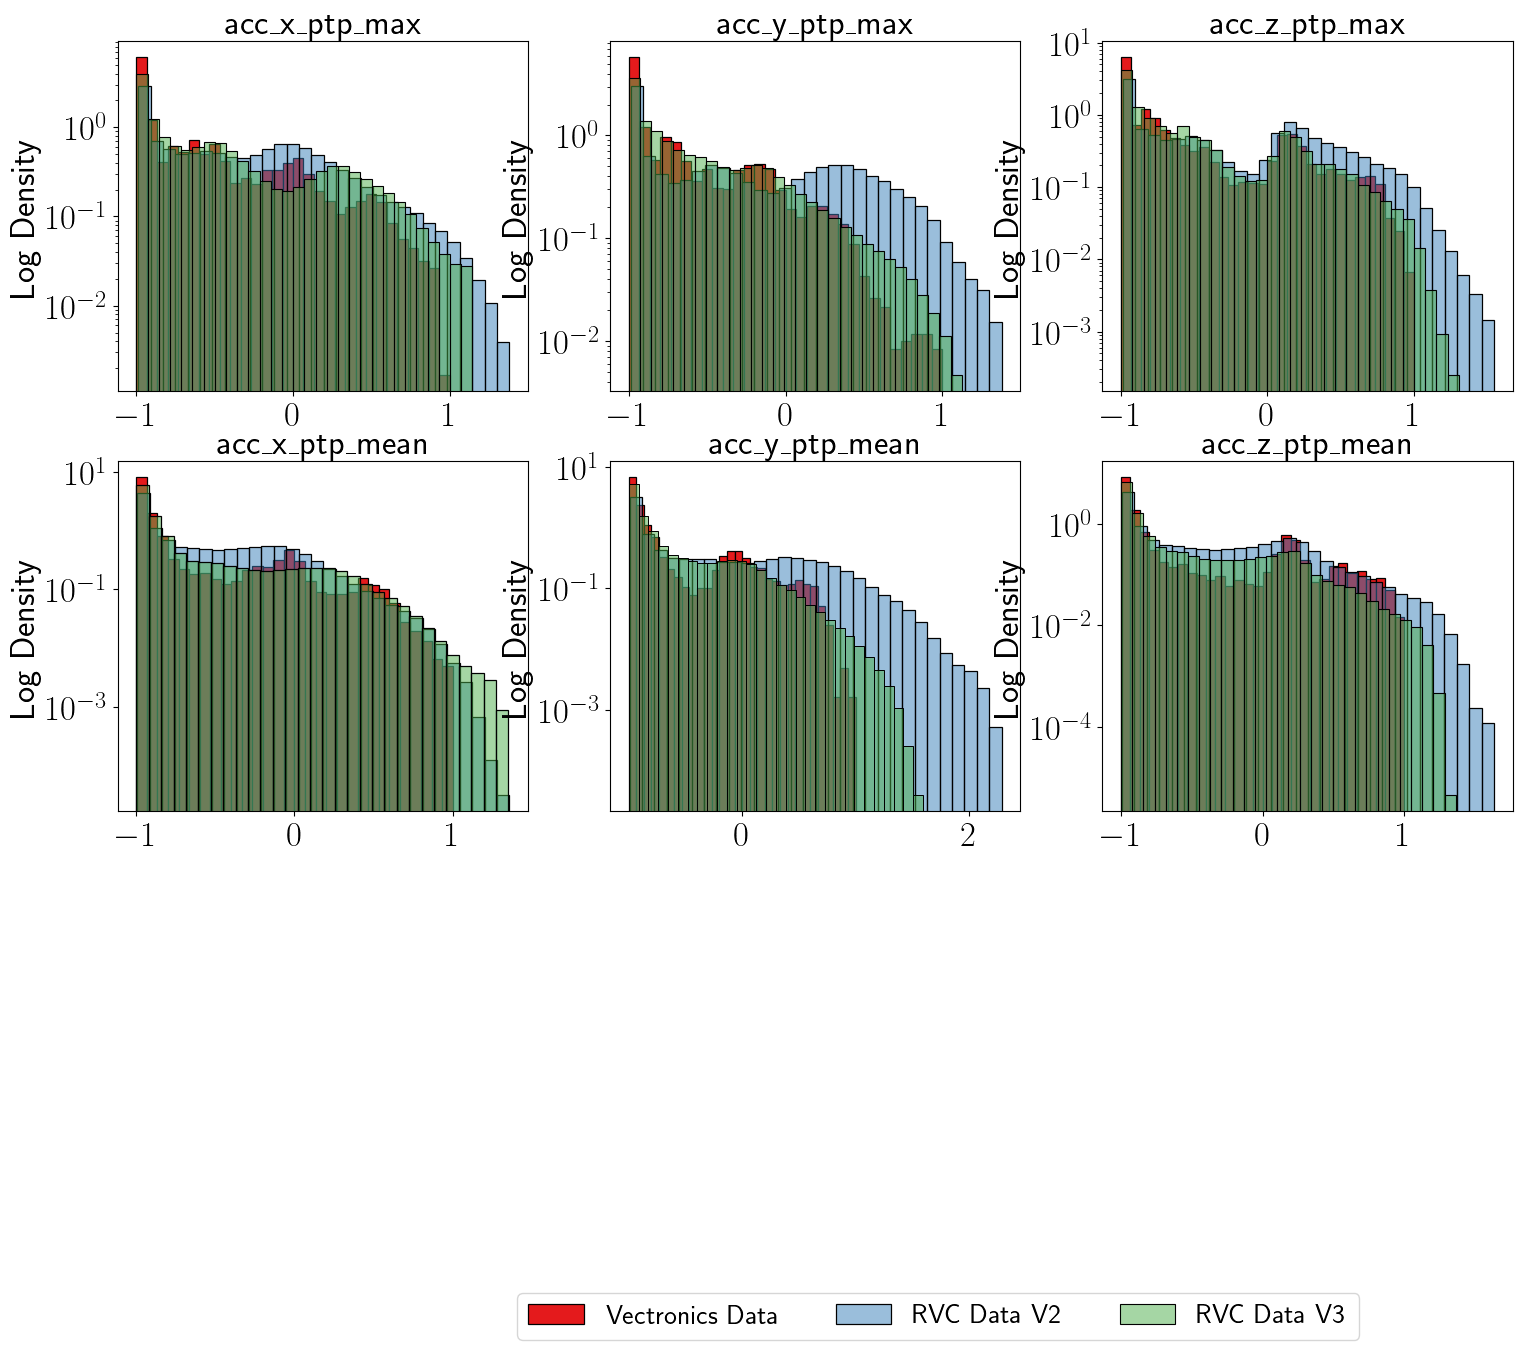

In [7]:
# Plot histograms of features
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("Set1", n_colors=3)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src[:,i].numpy(),
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )

        sns.histplot(X_targets[0][:,i].numpy(),
                kde=False,
                label='RVC Data V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.5
            )
        sns.histplot(X_targets[1][:,i].numpy(),
                kde=False,
                label='RVC Data V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.5
            )
    
        ax.set_title(col)
        ax.set_ylabel('Log Density')
        ax.set_yscale("log")
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(2.0, -2.75), ncol=3)

plt.tight_layout()
plt.show()


In [8]:
# objects for evaluation

sightings = pd.read_csv(io.get_sightings_path())
gps_moving = pd.read_csv(io.get_gps_moving_path())

## Method 1: CORAL

In [32]:
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", "target2")

with open(os.path.join(dir1, "training_stats.json"), 'r') as f:
    training_stats_list = json.load(f)
stats_df1 = pd.DataFrame(training_stats_list)
with open(os.path.join(dir2, "training_stats.json"), 'r') as f:
    training_stats_list = json.load(f)
stats_df2 = pd.DataFrame(training_stats_list)

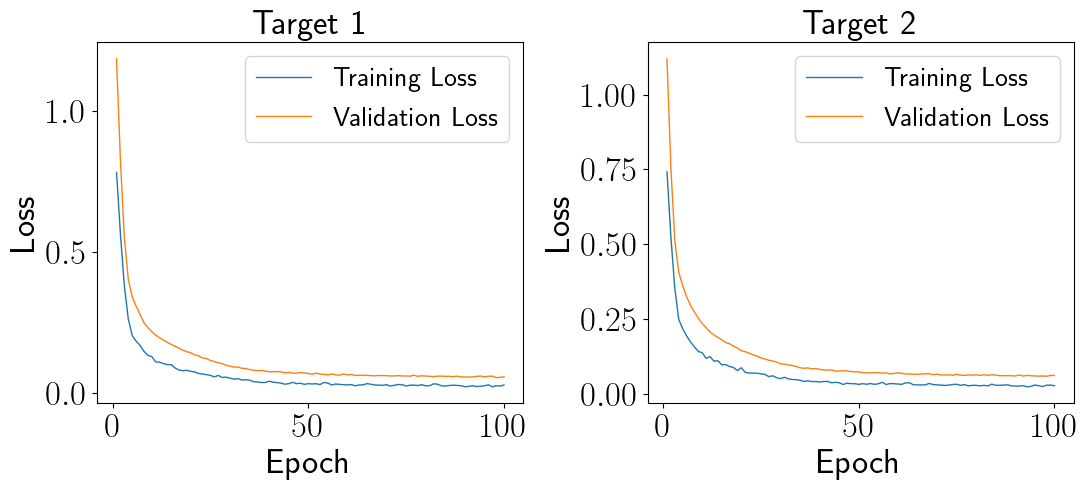

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

axs[0].plot(stats_df1['epoch'], stats_df1['Training Loss'], label='Training Loss')
axs[0].plot(stats_df1['epoch'], stats_df1['Validation Loss'], label='Validation Loss')
axs[0].set_title('Target 1')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(stats_df2['epoch'], stats_df2['Training Loss'], label='Training Loss')
axs[1].plot(stats_df2['epoch'], stats_df2['Validation Loss'], label='Validation Loss')
axs[1].set_title('Target 2')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

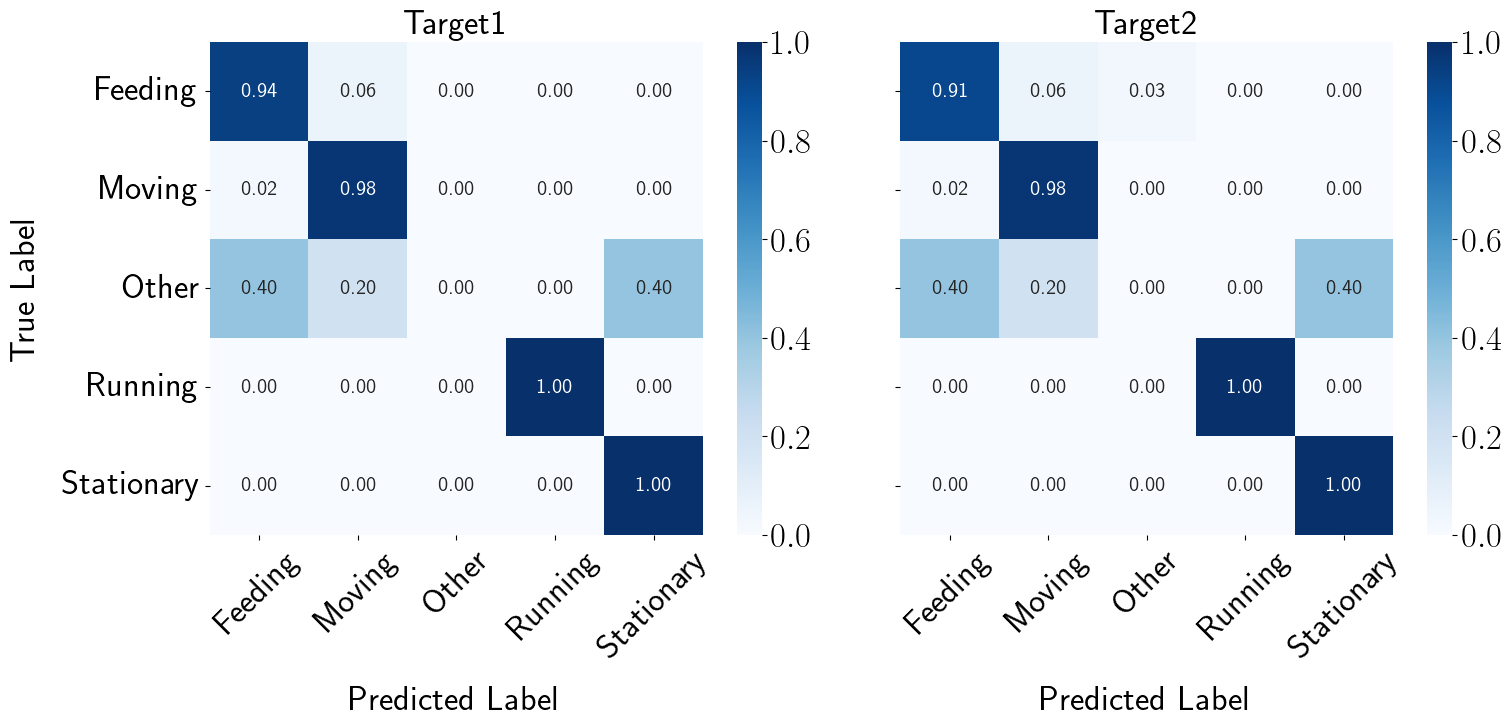

In [34]:
directories = [dir1, dir2]
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
class_names = label_encoder.classes_
for i, dir_path in enumerate(directories):
    ax = axes[i] # Select the subplot to draw on (axes[0] or axes[1])
    
    # Load the results file
    test_results = np.load(os.path.join(dir_path, "test_results.npz"))
    test_true = test_results["true_classes"]
    test_preds = test_results["predictions"]
    
    # Calculate the confusion matrix
    cm = confusion_matrix(
        y_true=label_encoder.inverse_transform(test_true),
        y_pred=label_encoder.inverse_transform(test_preds),
        labels=class_names,
        normalize='true' # Normalize to show proportions
    )
    
    # Plot the heatmap on the selected subplot
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, annot_kws={"size": 15}, ax=ax)
    
    # Customize labels and titles for each subplot
    ax.set_title(f"Target{i+1}")
    ax.set_xlabel("Predicted Label", labelpad=15)
    
    # Only show the y-label on the first plot
    if i == 0:
        ax.set_ylabel("True Label", labelpad=15)
    
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Adjust layout to prevent labels from overlapping and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
plt.show()

In [35]:
from src.methods.coral import SimpleFeatureNet

feat_dim = 128

for i, dir_path in enumerate(directories):
    coral_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)

    _, _, _ = evaluate_label_distribution(model=coral_model, 
                                    data=target_loaders[i],
                                    n_classes=len(np.unique(y_src)), 
                                    label_encoder=label_encoder,
                                    device=device, )
    

/tmp/ipykernel_3712409/3304071110.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location

Evaluating: 100%|██████████| 1223/1223 [00:03<00:00, 344.15it/s]
/tmp/ipykernel_3712409/3304071110.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state

Class Feeding: 32.850
Class Moving: 3.120
Class Other: 0.030
Class Running: 4.280
Class Stationary: 59.710


Evaluating: 100%|██████████| 5689/5689 [00:14<00:00, 399.97it/s]

Class Feeding: 7.990
Class Moving: 10.200
Class Other: 0.030
Class Running: 3.440
Class Stationary: 78.330


#### Label Distribution Calibration

In [36]:
n_clusters, batch_size = 100, 10000
cluster_dist1, cluster_centroids1, cluster_labels1 = func.compute_kmeans_distribution(X_targets[0], n_clusters=n_clusters, batch_size=batch_size, random_state=42)
cluster_dist2, cluster_centroids2, cluster_labels2 = func.compute_kmeans_distribution(X_targets[1], n_clusters=n_clusters, batch_size=batch_size, random_state=42)

coral_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model.load_state_dict(torch.load(os.path.join(directories[0], 'model.pt'), map_location=device))
coral_model.to(device)
coral_model.eval()
cluster_scores1 = coral_model(torch.tensor(cluster_centroids1, dtype=torch.float32).to(device))[1]
cluster_scores1 = F.softmax(cluster_scores1, dim=1).detach().cpu().numpy()

coral_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model.load_state_dict(torch.load(os.path.join(directories[1], 'model.pt'), map_location=device))
coral_model.to(device)
coral_model.eval()
cluster_scores2 = coral_model(torch.tensor(cluster_centroids2, dtype=torch.float32).to(device))[1]
cluster_scores2 = F.softmax(cluster_scores2, dim=1).detach().cpu().numpy()

/tmp/ipykernel_3712409/559986816.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(directories[0], 'model.pt'), map_loc

In [37]:
import ot

label_dist = np.array([2.55, 4.48, 3.55, 1.96, 87.45])
label_dist = label_dist / label_dist.sum()

reg = 0.01
cost_matrix1 = - reg * np.log(cluster_scores1 * cluster_dist1[:, np.newaxis])
P1 = ot.sinkhorn(cluster_dist1, label_dist, cost_matrix1, reg)

cost_matrix2 = - reg * np.log(cluster_scores2 * cluster_dist2[:, np.newaxis])
P2 = ot.sinkhorn(cluster_dist2, label_dist, cost_matrix2, reg)

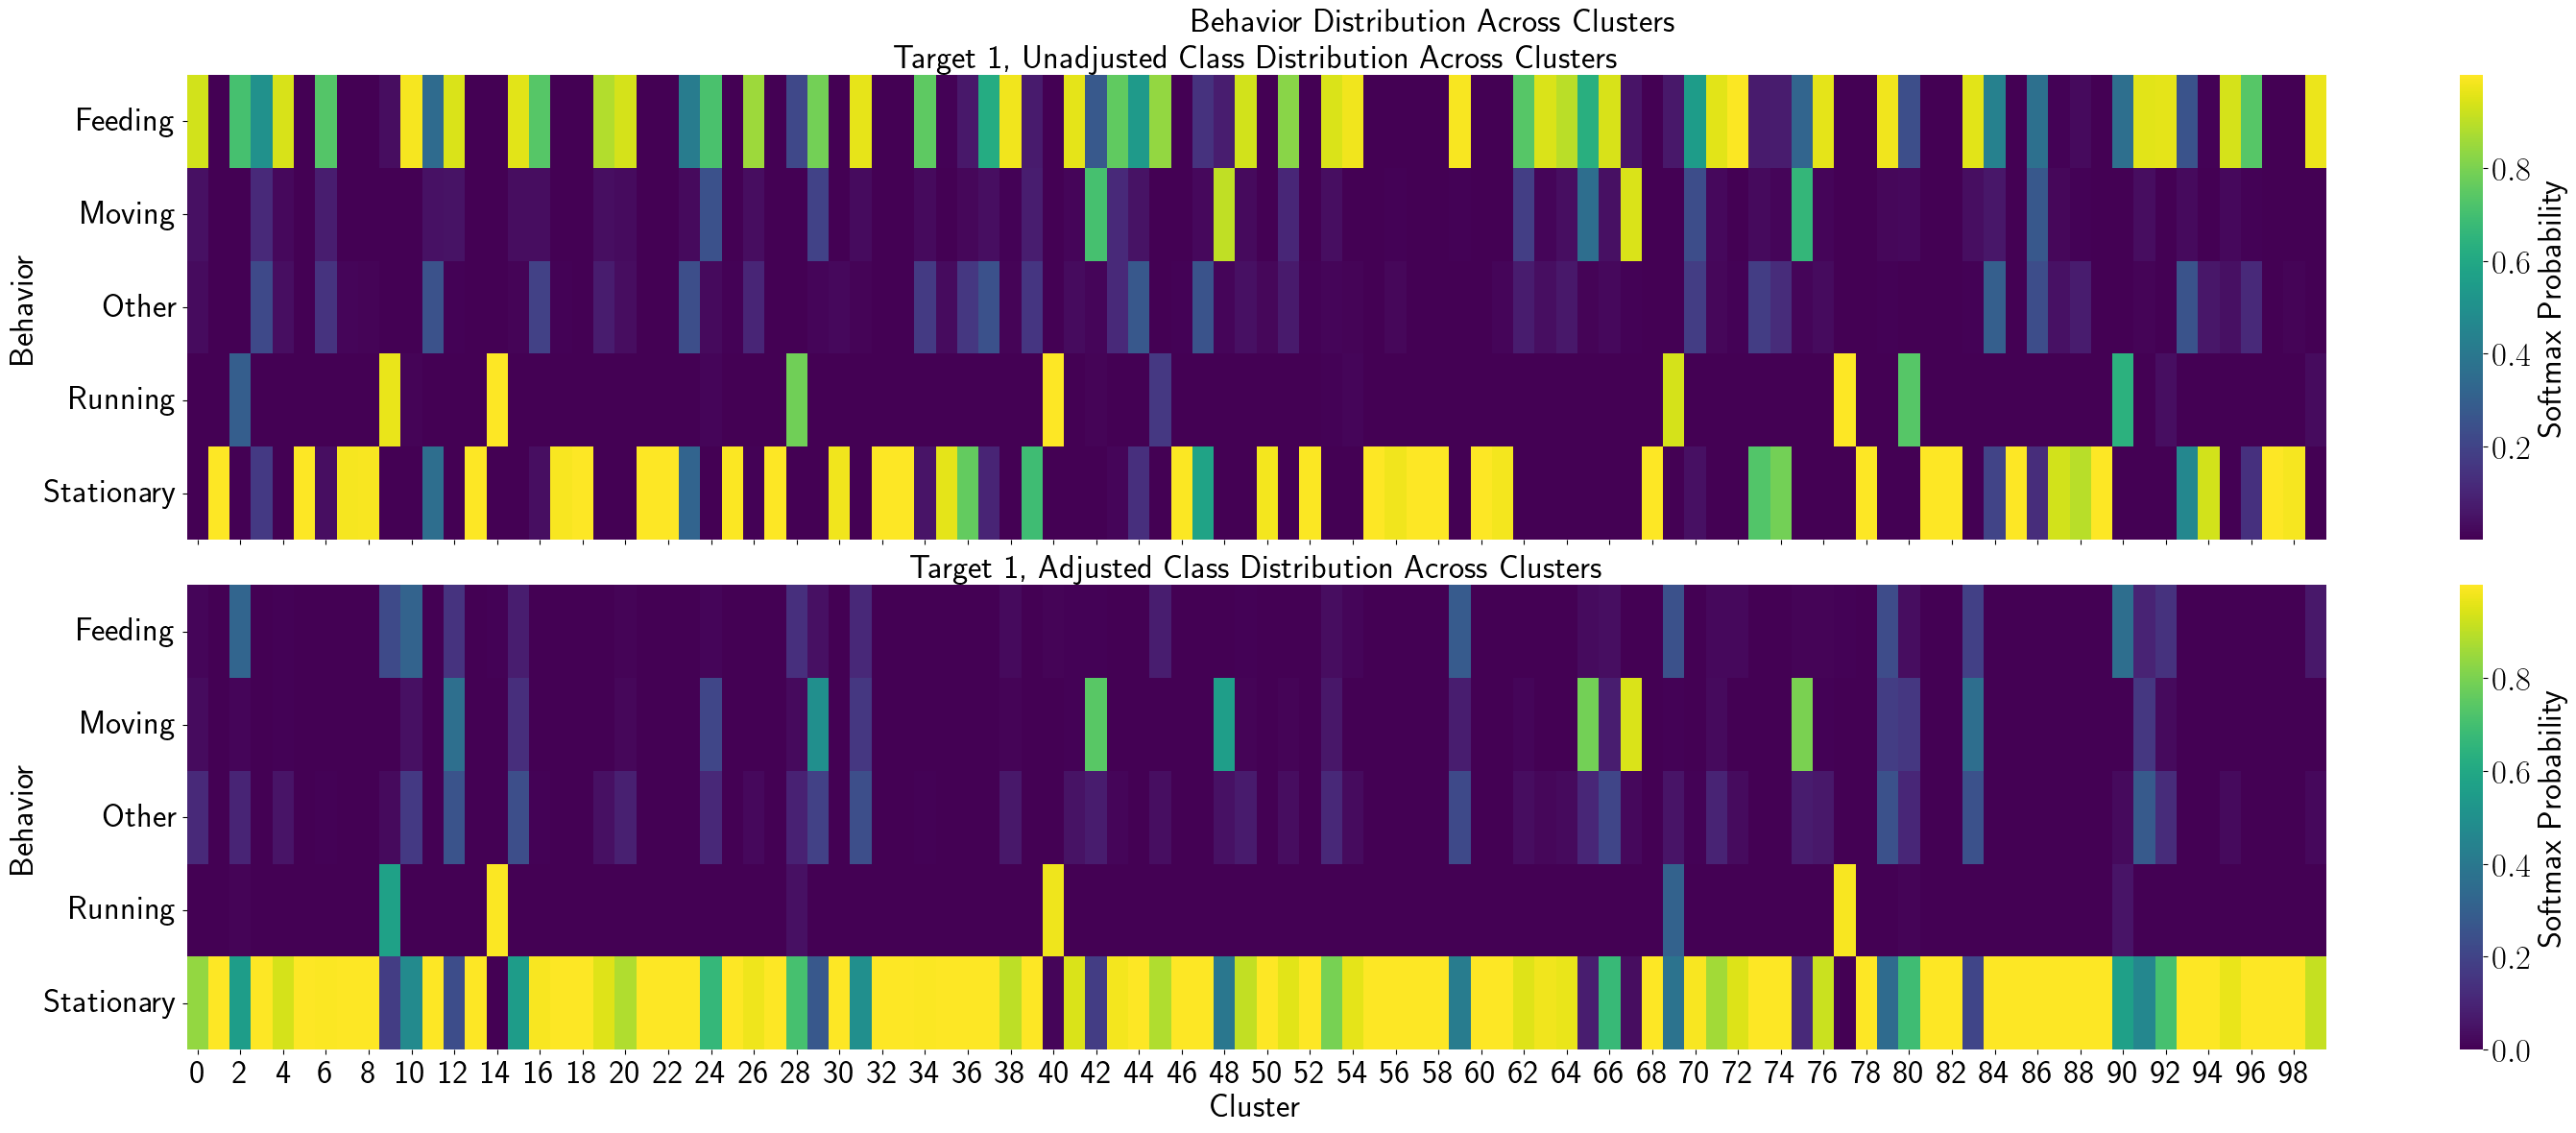

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(30, 12), sharex=True, sharey=True)
sns.heatmap(
    cluster_scores1.T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores1.shape[1])] ,
    ax=axs[0]
)
sns.heatmap(
    (P1 / cluster_dist1[:, np.newaxis]).T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[1]
)

axs[1].set_xlabel("Cluster")
axs[0].set_ylabel("Behavior")
axs[1].set_ylabel("Behavior")

axs[0].set_title("Target 1, Unadjusted Class Distribution Across Clusters")
axs[1].set_title("Target 1, Adjusted Class Distribution Across Clusters")
plt.suptitle("Behavior Distribution Across Clusters", fontsize=25)

# Rotate x-axis labels to horizontal
axs[1].tick_params(axis='x', rotation=0)   
axs[1].tick_params(axis='y', rotation=0)   

plt.tight_layout()
plt.show()


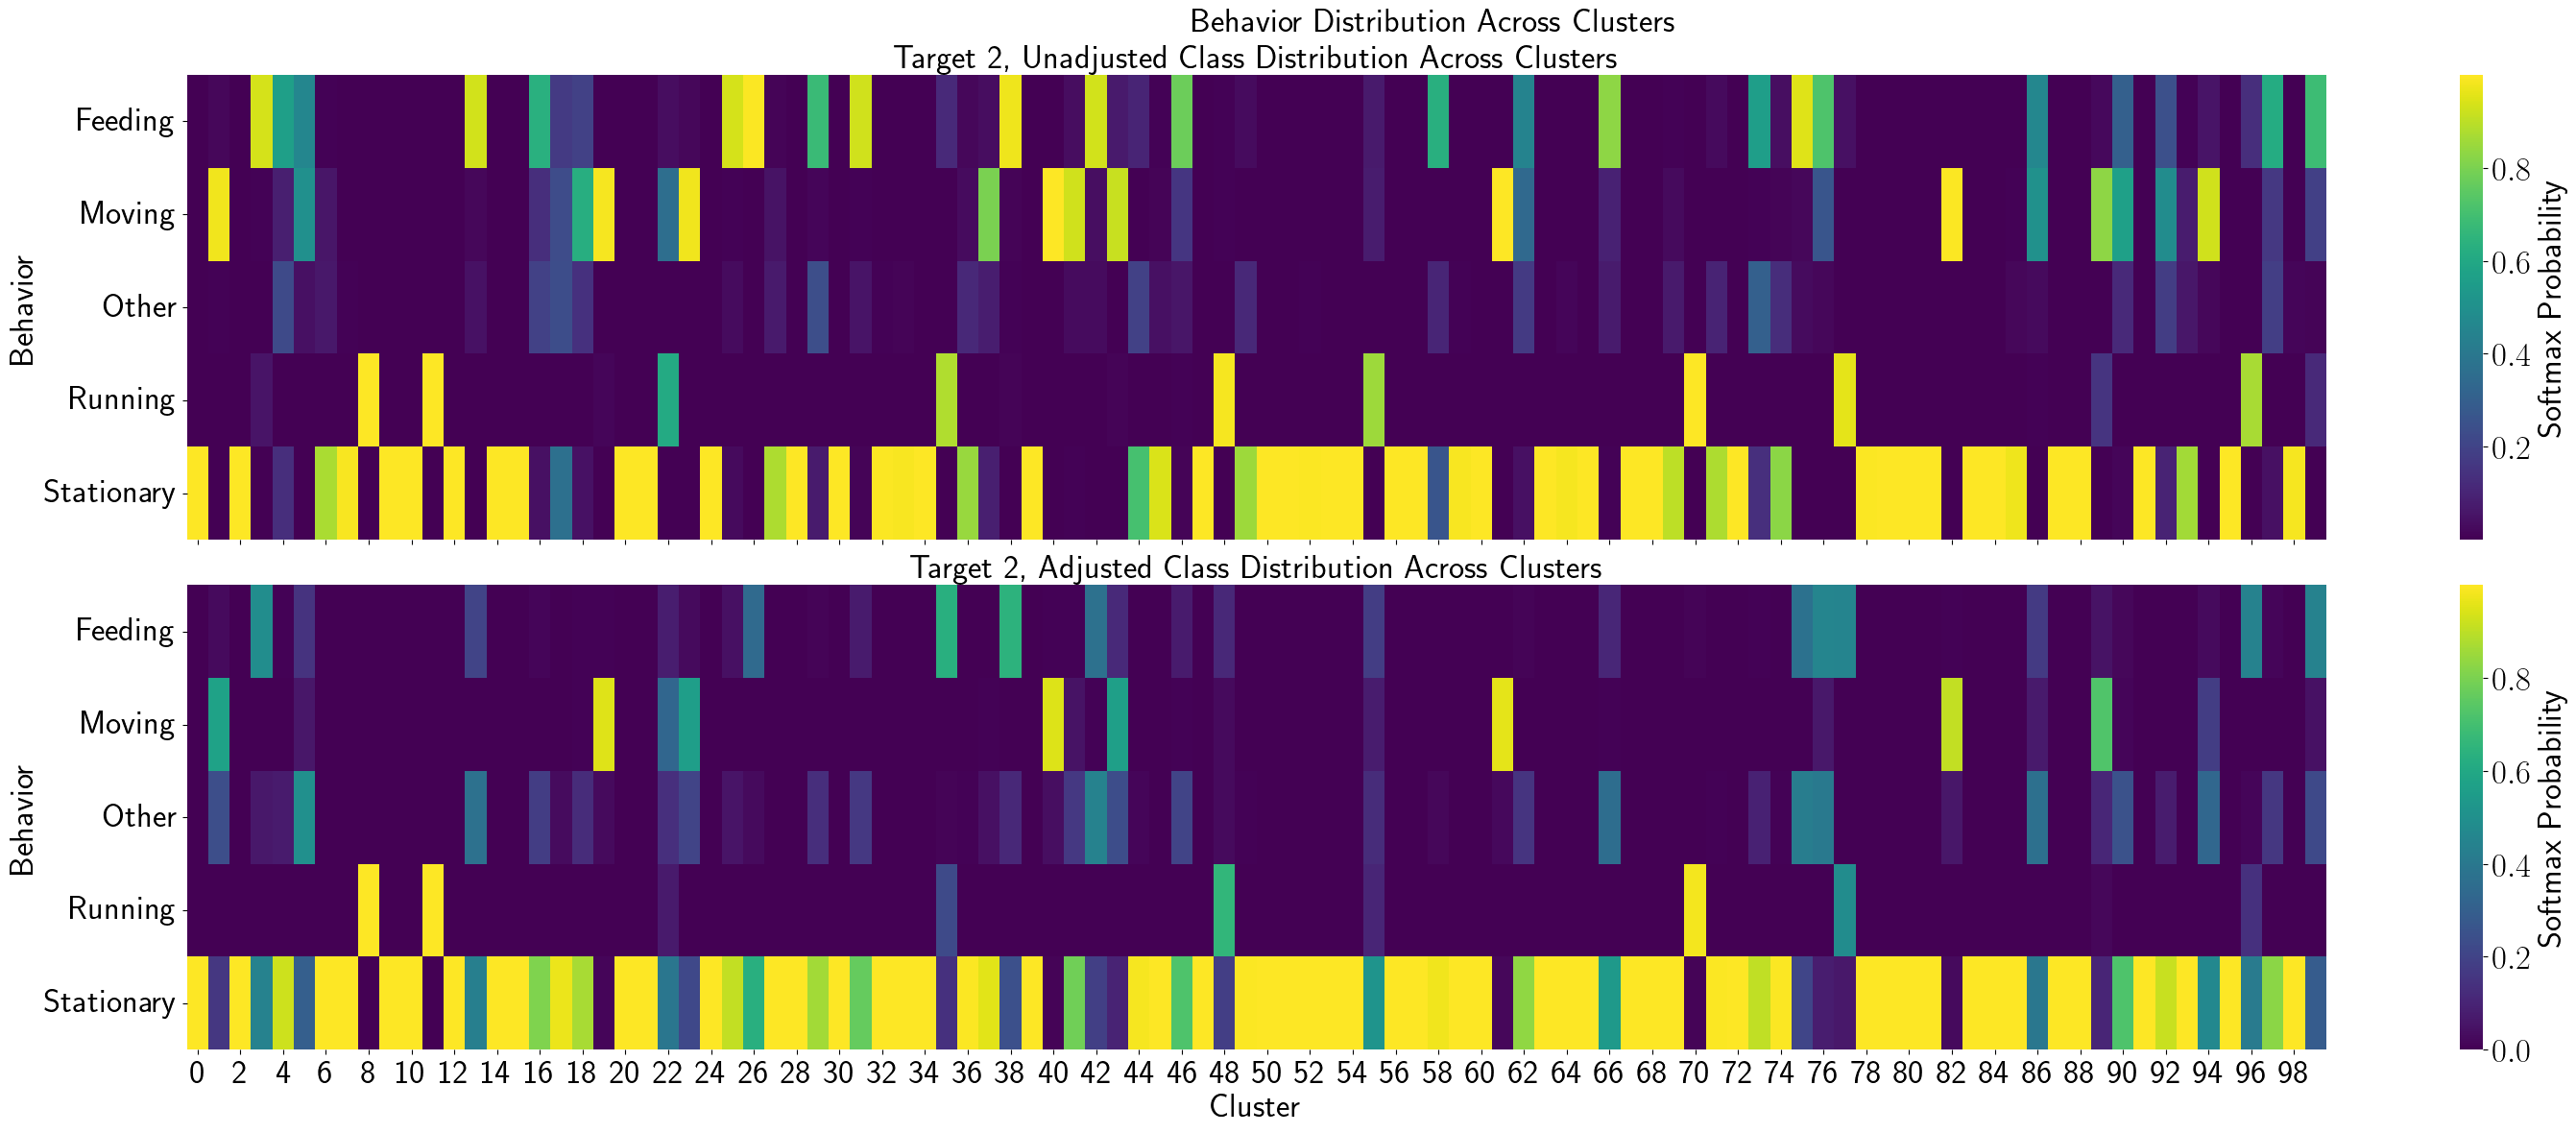

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(30, 12), sharex=True, sharey=True)
sns.heatmap(
    cluster_scores2.T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[0]
)
sns.heatmap(
    (P2 / cluster_dist2[:, np.newaxis]).T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[1]
)

axs[1].set_xlabel("Cluster")
axs[0].set_ylabel("Behavior")
axs[1].set_ylabel("Behavior")

axs[0].set_title("Target 2, Unadjusted Class Distribution Across Clusters")
axs[1].set_title("Target 2, Adjusted Class Distribution Across Clusters")
plt.suptitle("Behavior Distribution Across Clusters", fontsize=25)

# Rotate x-axis labels to horizontal
axs[1].tick_params(axis='x', rotation=0)   
axs[1].tick_params(axis='y', rotation=0)   

plt.tight_layout()
plt.show()


In [40]:
unadjusted_label_dist1 = np.sum(cluster_scores1 * cluster_dist1[:, np.newaxis], axis=0)
adjusted_label_dist1 = np.sum(P1, axis=0)

unadjusted_label_dist2 = np.sum(cluster_scores2 * cluster_dist2[:, np.newaxis], axis=0)
adjusted_label_dist2 = np.sum(P2, axis=0)

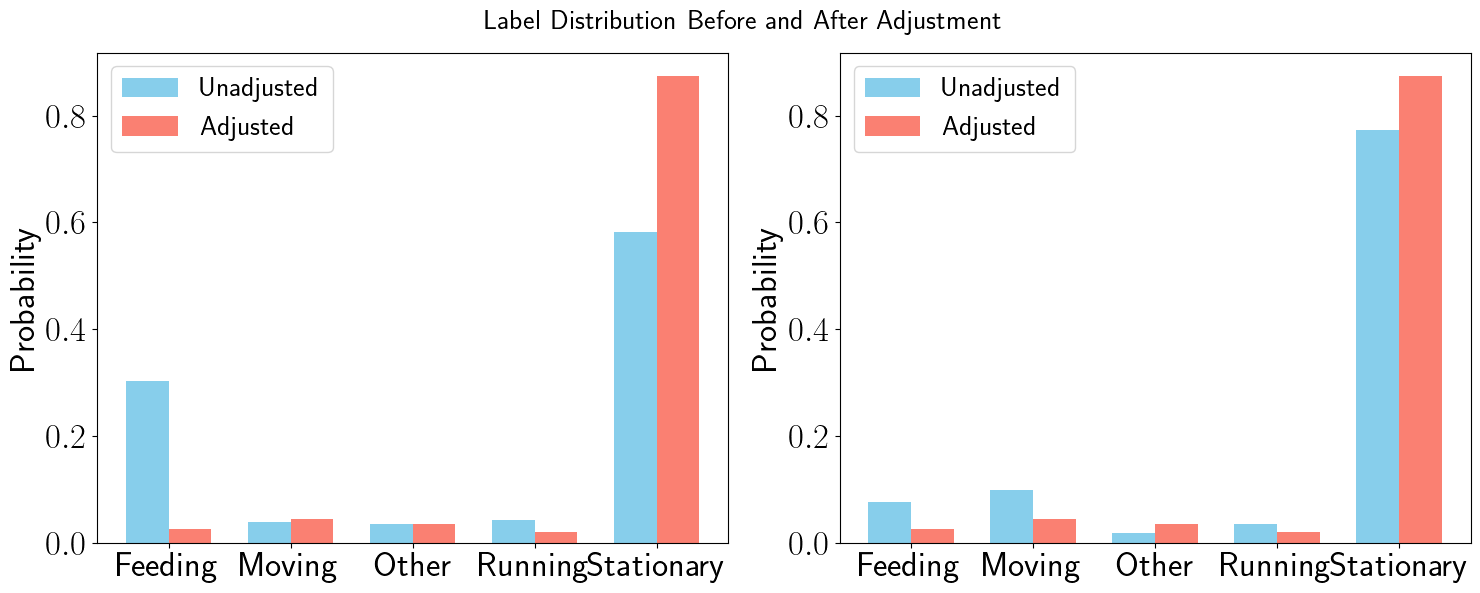

In [41]:
# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
x = np.arange(len(config.SUMMARY_BEHAVIORS))
width = 0.35
# Plot bars side by side
rects1 = ax[0].bar(x - width/2, unadjusted_label_dist1, width, label='Unadjusted', color='skyblue')
rects2 = ax[0].bar(x + width/2, adjusted_label_dist1, width, label='Adjusted', color='salmon')

# Custom x-axis labels
ax[0].set_xticks(x)
ax[0].set_xticklabels(config.SUMMARY_BEHAVIORS)

# Labels, title, legend
ax[0].set_ylabel('Probability')
ax[0].legend()

# Second subplot
rects1 = ax[1].bar(x - width/2, unadjusted_label_dist2, width, label='Unadjusted', color='skyblue')
rects2 = ax[1].bar(x + width/2, adjusted_label_dist2, width, label='Adjusted', color='salmon')

# Custom x-axis labels
ax[1].set_xticks(x)
ax[1].set_xticklabels(config.SUMMARY_BEHAVIORS)

# Labels, title, legend
ax[1].set_ylabel('Probability')
ax[1].legend()

plt.suptitle("Label Distribution Before and After Adjustment", fontsize=20)
plt.tight_layout()

plt.show()

In [42]:
adjusted_scores1 = P1 / cluster_dist1[:, np.newaxis]
adjusted_scores2 = P2 / cluster_dist2[:, np.newaxis]

In [43]:
from src.eval.plot_utils import make_sightings_plots_from_clusters
_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=X_targets[1],
                                   metadata=RVC_df[RVC_df.firmware_major_version == 3.0].reset_index(drop=True),
                                   matched_sightings=sightings, 
                                   matched_gps=gps_moving, 
                                   label_name="coral")

Processing animal-days: 100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


## Method 2: DANN

In [44]:
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "dann", "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "dann", "target2")

with open(os.path.join(dir1, "training_stats.json"), 'r') as f:
    training_stats_list = json.load(f)
stats_df1 = pd.DataFrame(training_stats_list)
with open(os.path.join(dir2, "training_stats.json"), 'r') as f:
    training_stats_list = json.load(f)
stats_df2 = pd.DataFrame(training_stats_list)

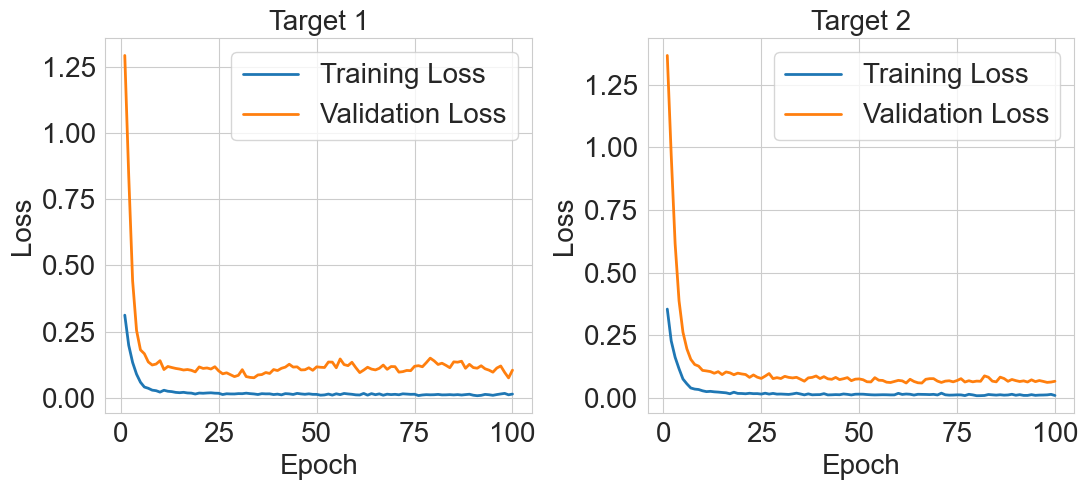

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

axs[0].plot(stats_df1['epoch'], stats_df1['Training Loss'], label='Training Loss')
axs[0].plot(stats_df1['epoch'], stats_df1['Validation Loss'], label='Validation Loss')
axs[0].set_title('Target 1')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(stats_df2['epoch'], stats_df2['Training Loss'], label='Training Loss')
axs[1].plot(stats_df2['epoch'], stats_df2['Validation Loss'], label='Validation Loss')
axs[1].set_title('Target 2')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

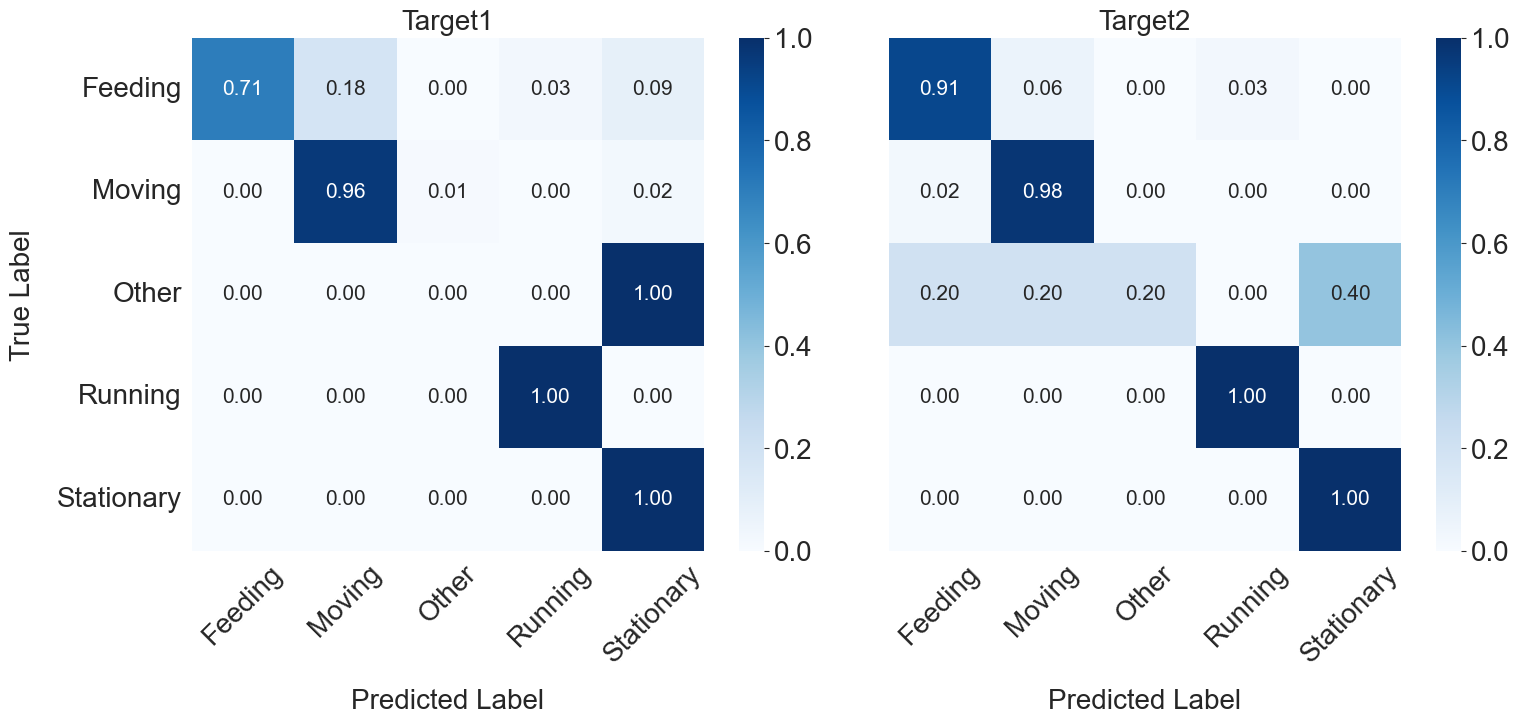

In [46]:
directories = [dir1, dir2]
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
class_names = label_encoder.classes_
for i, dir_path in enumerate(directories):
    ax = axes[i] # Select the subplot to draw on (axes[0] or axes[1])
    
    # Load the results file
    test_results = np.load(os.path.join(dir_path, "test_results.npz"))
    test_true = test_results["true_classes"]
    test_preds = test_results["predictions"]
    
    # Calculate the confusion matrix
    cm = confusion_matrix(
        y_true=label_encoder.inverse_transform(test_true),
        y_pred=label_encoder.inverse_transform(test_preds),
        labels=class_names,
        normalize='true' # Normalize to show proportions
    )
    
    # Plot the heatmap on the selected subplot
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, annot_kws={"size": 15}, ax=ax)
    
    # Customize labels and titles for each subplot
    ax.set_title(f"Target{i+1}")
    ax.set_xlabel("Predicted Label", labelpad=15)
    
    # Only show the y-label on the first plot
    if i == 0:
        ax.set_ylabel("True Label", labelpad=15)
    
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Adjust layout to prevent labels from overlapping and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
plt.show()

In [48]:
from src.methods.dann import DANNModel, FeatureExtractor, LabelClassifier, DomainClassifier

hidden_dim = 128
feat = FeatureExtractor(in_dim=X_src.shape[-1], hidden_dim=hidden_dim).to(device)
clf = LabelClassifier(in_dim=hidden_dim, n_classes=len(np.unique(y_src))).to(device)
dom = DomainClassifier(in_dim=hidden_dim).to(device)
dann_model = DANNModel(feat, clf, dom).to(device)



for i, loader in enumerate(target_loaders):
    dann_model.load_state_dict(torch.load(os.path.join(directories[i], 'model.pt'), map_location=device))
    dann_model.to(device)

    _, _, _ = evaluate_label_distribution(model=dann_model, 
                                    data=loader,
                                    n_classes=len(np.unique(y_src)), 
                                    label_encoder=label_encoder,
                                    device=device, 
                                    verbose=True)

/tmp/ipykernel_3712409/3109182295.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dann_model.load_state_dict(torch.load(os.path.join(directories[i], 'model.pt'), map_lo

Class Feeding: 24.570
Class Moving: 6.630
Class Other: 0.360
Class Running: 5.460
Class Stationary: 62.990


Evaluating: 100%|██████████| 5689/5689 [00:12<00:00, 463.28it/s]

Class Feeding: 6.060
Class Moving: 10.560
Class Other: 0.390
Class Running: 4.340
Class Stationary: 78.650


#### Label Distribution Calibration

In [49]:
n_clusters, batch_size = 100, 10000
cluster_dist1, cluster_centroids1, cluster_labels1 = func.compute_kmeans_distribution(X_targets[0], n_clusters=n_clusters, batch_size=batch_size, random_state=42)
cluster_dist2, cluster_centroids2, cluster_labels2 = func.compute_kmeans_distribution(X_targets[1], n_clusters=n_clusters, batch_size=batch_size, random_state=42)

dann_model.eval()
cluster_scores1 = dann_model(torch.tensor(cluster_centroids1, dtype=torch.float32).to(device))
cluster_scores1 = F.softmax(cluster_scores1, dim=1).detach().cpu().numpy()

dann_model.eval()
cluster_scores2 = dann_model(torch.tensor(cluster_centroids2, dtype=torch.float32).to(device))
cluster_scores2 = F.softmax(cluster_scores2, dim=1).detach().cpu().numpy()

In [50]:
import ot

label_dist = np.array([2.55, 4.48, 3.55, 1.96, 87.45])
label_dist = label_dist / label_dist.sum()

reg = 0.1
cost_matrix1 = - reg * np.log(cluster_scores1 * cluster_dist1[:, np.newaxis])
P1 = ot.sinkhorn(cluster_dist1, label_dist, cost_matrix1, reg)

cost_matrix2 = - reg * np.log(cluster_scores2 * cluster_dist2[:, np.newaxis])
P2 = ot.sinkhorn(cluster_dist2, label_dist, cost_matrix2, reg)

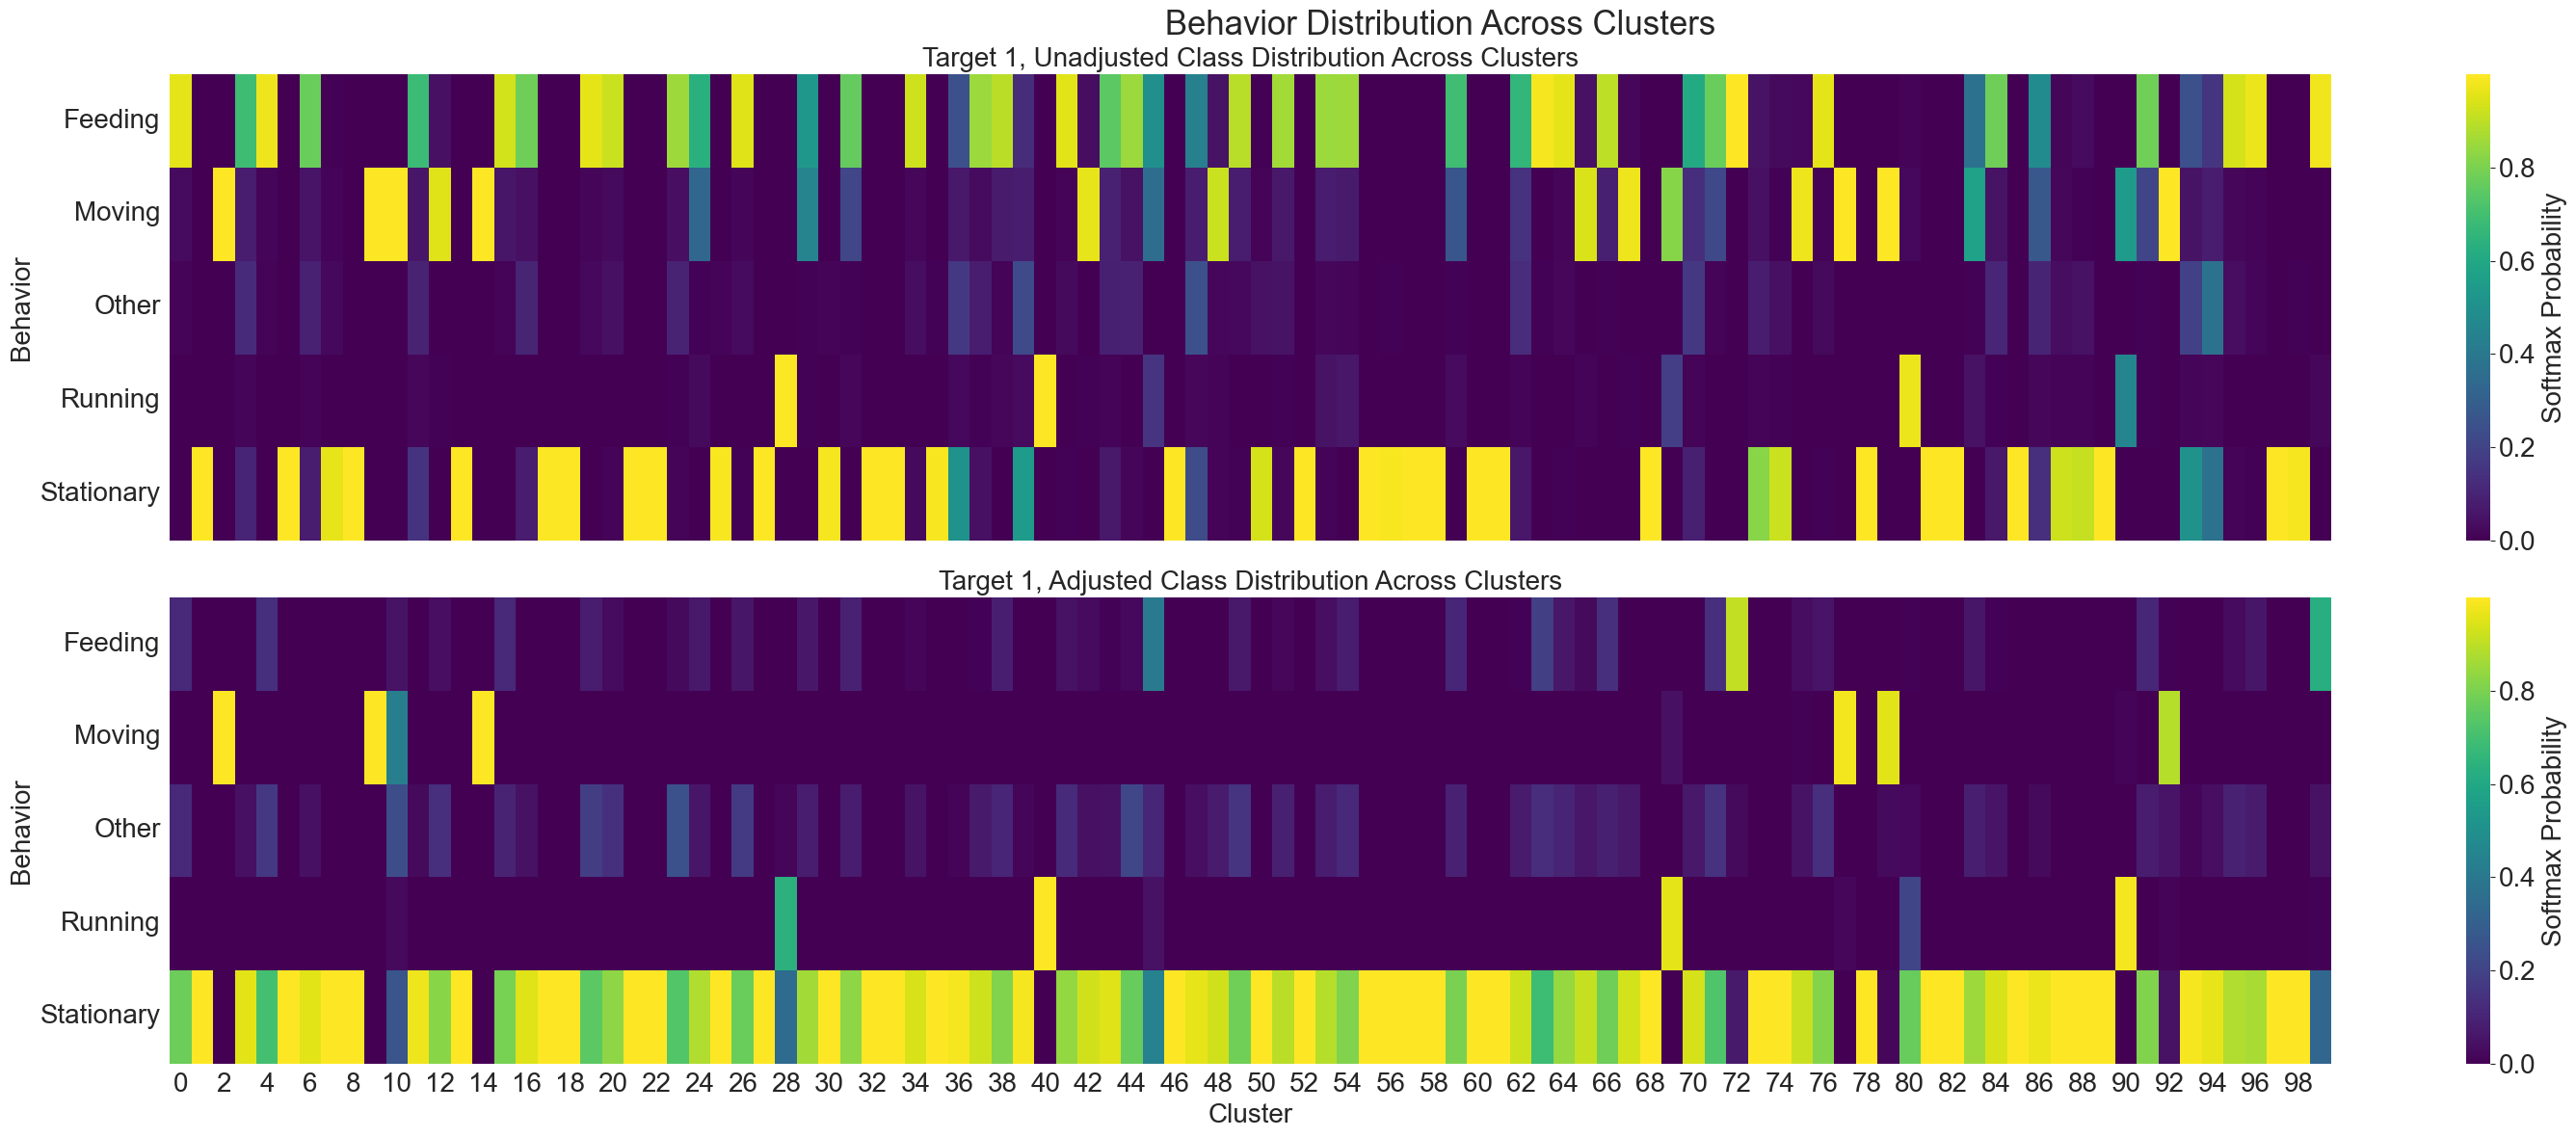

In [51]:
fig, axs = plt.subplots(2, 1, figsize=(30, 12), sharex=True, sharey=True)
sns.heatmap(
    cluster_scores1.T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores1.shape[1])] ,
    ax=axs[0]
)
sns.heatmap(
    (P1 / cluster_dist1[:, np.newaxis]).T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[1]
)

axs[1].set_xlabel("Cluster")
axs[0].set_ylabel("Behavior")
axs[1].set_ylabel("Behavior")

axs[0].set_title("Target 1, Unadjusted Class Distribution Across Clusters")
axs[1].set_title("Target 1, Adjusted Class Distribution Across Clusters")
plt.suptitle("Behavior Distribution Across Clusters", fontsize=25)

# Rotate x-axis labels to horizontal
axs[1].tick_params(axis='x', rotation=0)   
axs[1].tick_params(axis='y', rotation=0)   

plt.tight_layout()
plt.show()


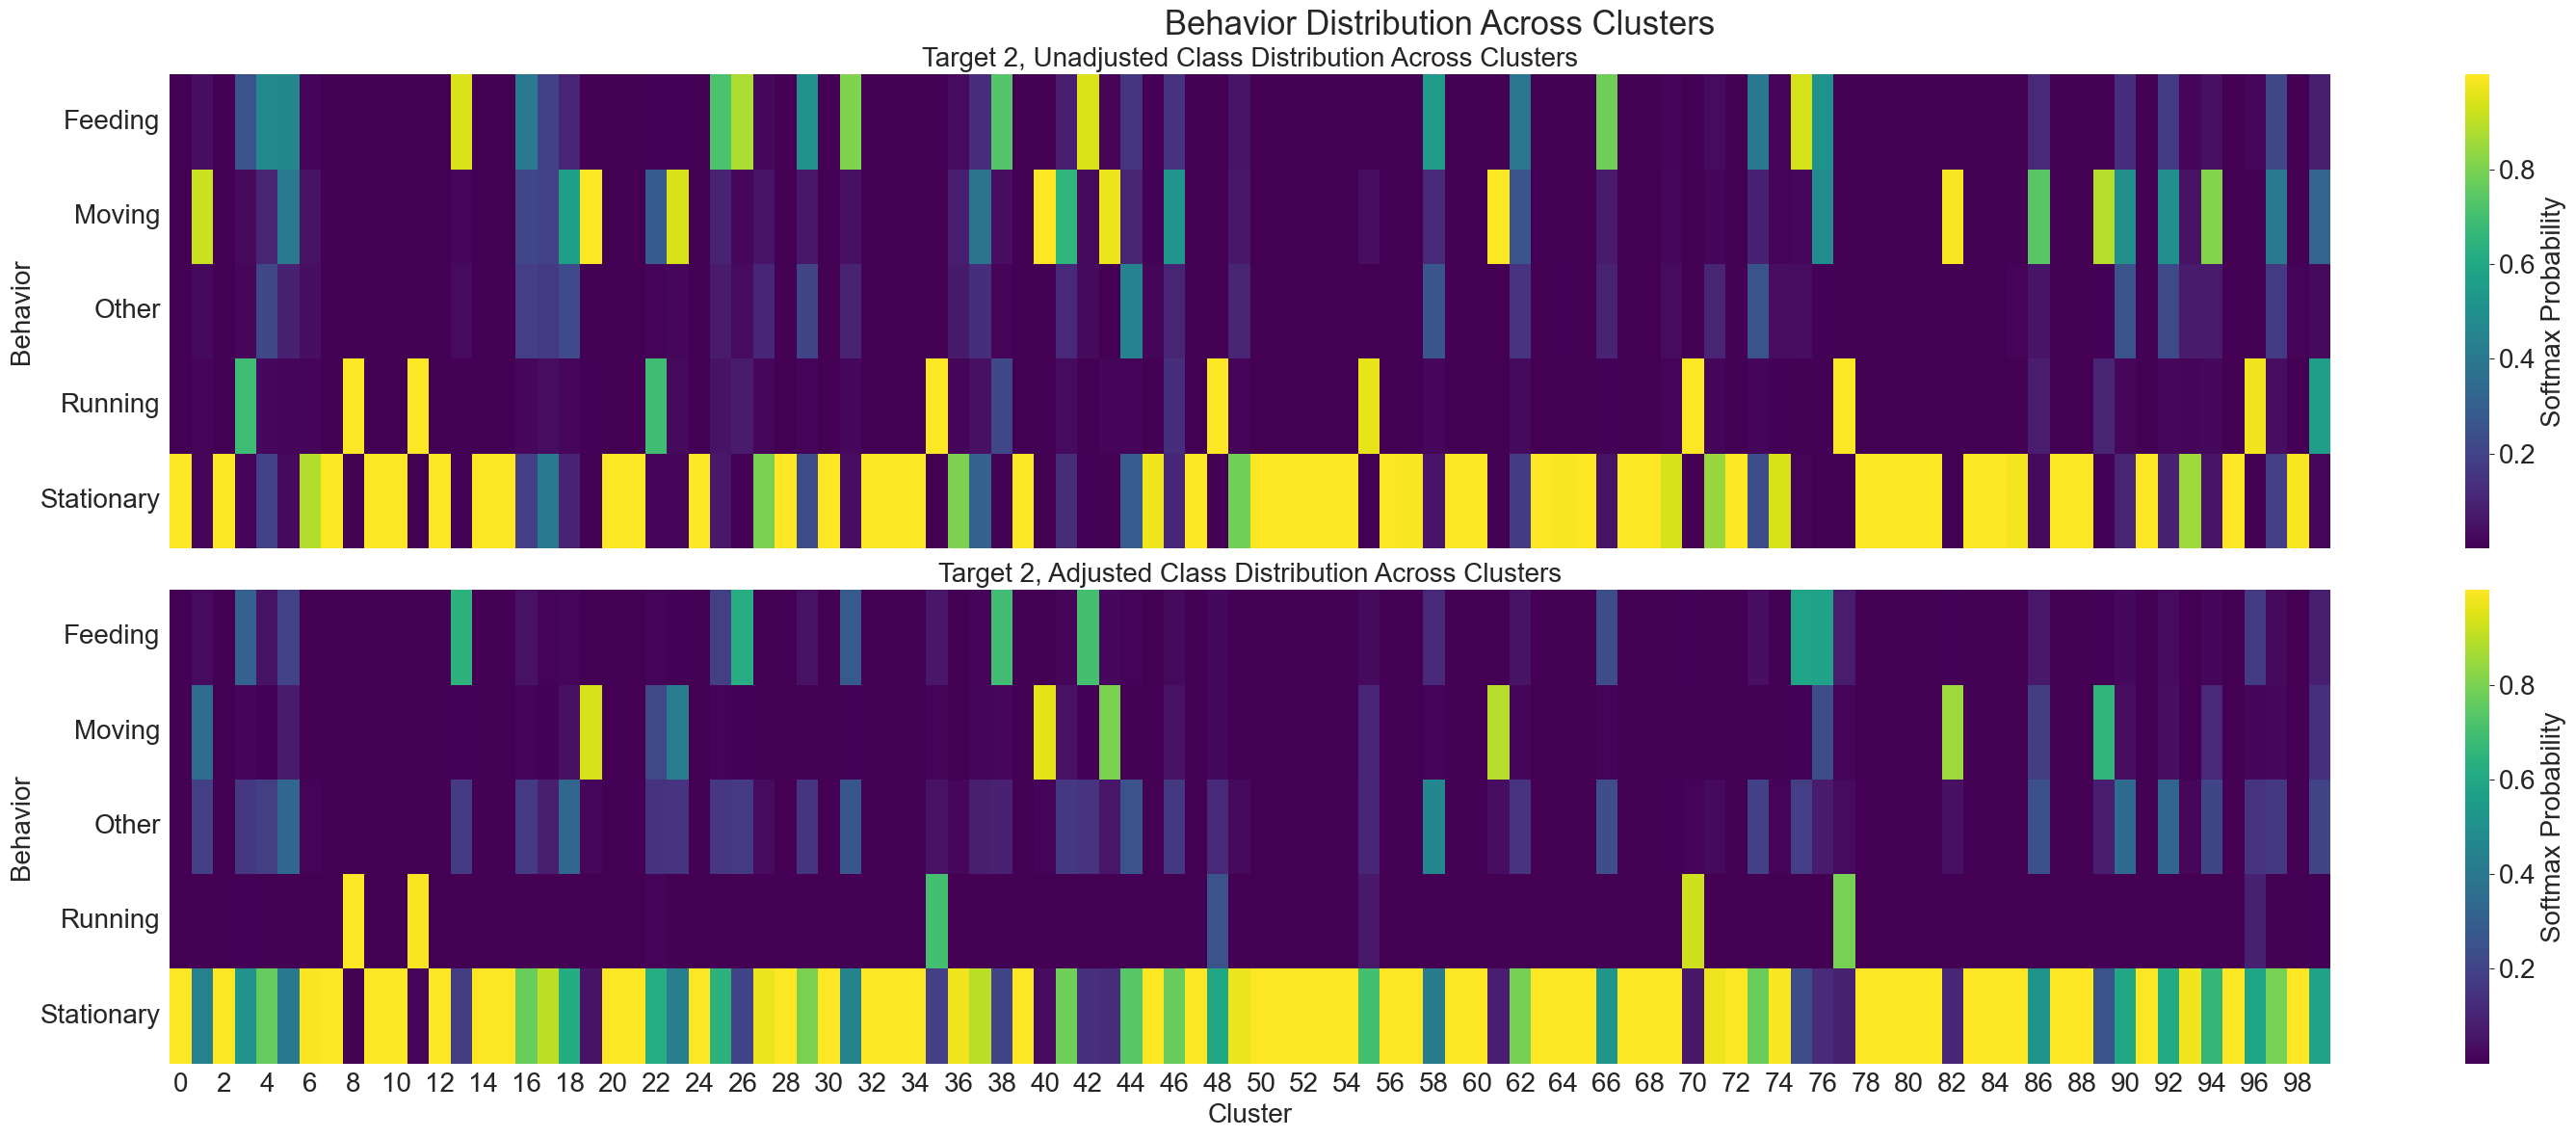

In [52]:
fig, axs = plt.subplots(2, 1, figsize=(30, 12), sharex=True, sharey=True)
sns.heatmap(
    cluster_scores2.T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[0]
)
sns.heatmap(
    (P2 / cluster_dist2[:, np.newaxis]).T,
    cmap='viridis',
    cbar_kws={'label': 'Softmax Probability'},
    # xticklabels=[str(i) for i in range(cluster_scores.shape[0])],  # clusters on x-axis
    yticklabels=[label_encoder.inverse_transform([i])[0] for i in range(cluster_scores2.shape[1])] ,
    ax=axs[1]
)

axs[1].set_xlabel("Cluster")
axs[0].set_ylabel("Behavior")
axs[1].set_ylabel("Behavior")

axs[0].set_title("Target 2, Unadjusted Class Distribution Across Clusters")
axs[1].set_title("Target 2, Adjusted Class Distribution Across Clusters")
plt.suptitle("Behavior Distribution Across Clusters", fontsize=25)

# Rotate x-axis labels to horizontal
axs[1].tick_params(axis='x', rotation=0)   
axs[1].tick_params(axis='y', rotation=0)   

plt.tight_layout()
plt.show()


In [53]:
unadjusted_label_dist1 = np.sum(cluster_scores1 * cluster_dist1[:, np.newaxis], axis=0)
adjusted_label_dist1 = np.sum(P1, axis=0)

unadjusted_label_dist2 = np.sum(cluster_scores2 * cluster_dist2[:, np.newaxis], axis=0)
adjusted_label_dist2 = np.sum(P2, axis=0)

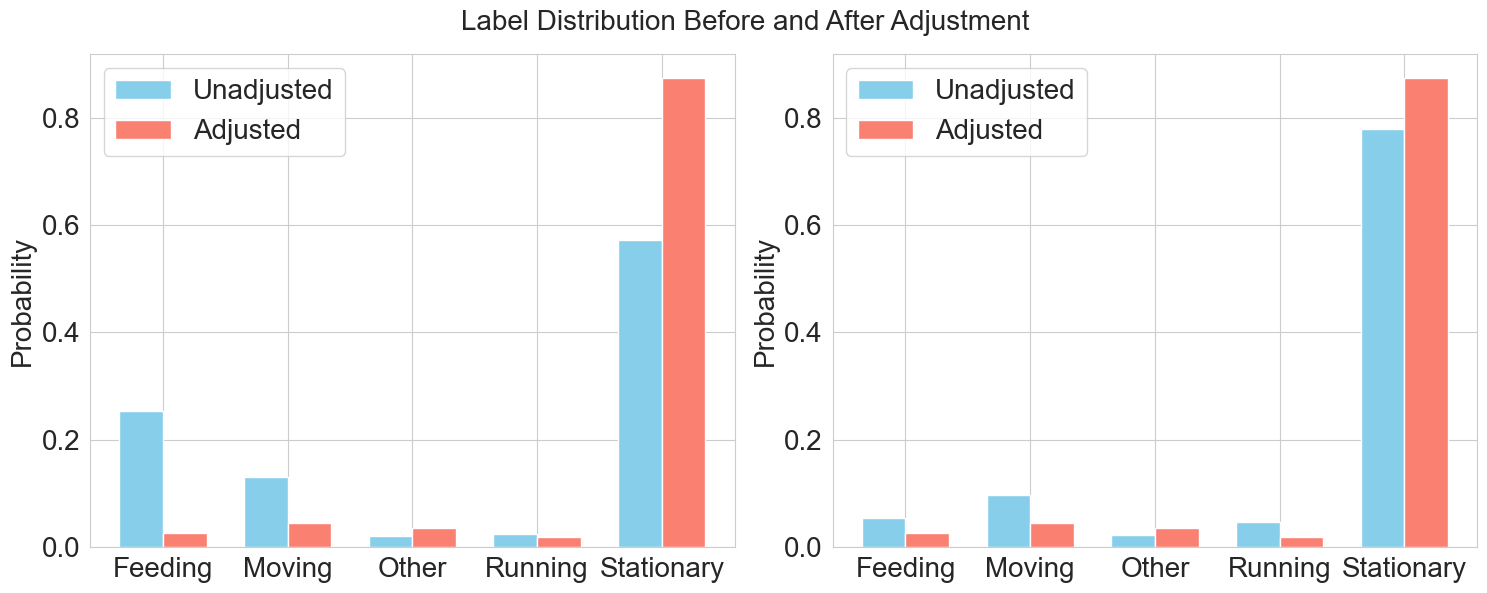

In [54]:
# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
x = np.arange(len(config.SUMMARY_BEHAVIORS))
width = 0.35
# Plot bars side by side
rects1 = ax[0].bar(x - width/2, unadjusted_label_dist1, width, label='Unadjusted', color='skyblue')
rects2 = ax[0].bar(x + width/2, adjusted_label_dist1, width, label='Adjusted', color='salmon')

# Custom x-axis labels
ax[0].set_xticks(x)
ax[0].set_xticklabels(config.SUMMARY_BEHAVIORS)

# Labels, title, legend
ax[0].set_ylabel('Probability')
ax[0].legend()

# Second subplot
rects1 = ax[1].bar(x - width/2, unadjusted_label_dist2, width, label='Unadjusted', color='skyblue')
rects2 = ax[1].bar(x + width/2, adjusted_label_dist2, width, label='Adjusted', color='salmon')

# Custom x-axis labels
ax[1].set_xticks(x)
ax[1].set_xticklabels(config.SUMMARY_BEHAVIORS)

# Labels, title, legend
ax[1].set_ylabel('Probability')
ax[1].legend()

plt.suptitle("Label Distribution Before and After Adjustment", fontsize=20)
plt.tight_layout()

plt.show()

In [55]:
adjusted_scores1 = P1 / cluster_dist1[:, np.newaxis]
adjusted_scores2 = P2 / cluster_dist2[:, np.newaxis]

In [56]:
from src.eval.plot_utils import make_sightings_plots_from_clusters
_ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
                                   cluster_scores=adjusted_scores2,
                                   data=X_targets[1],
                                   metadata=RVC_df[RVC_df.firmware_major_version == 3.0].reset_index(drop=True),
                                   matched_sightings=sightings, 
                                   matched_gps=gps_moving, )

Processing animal-days: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
